### 2D Sheared rectangle

2D Sheared rectangle case from Jourdon & May (2022)


### Reference

- Jourdon, A., & May, D. A. (2022). An efficient parallel method to compute lithostatic pressure in thermo-mechanical geodynamic models. Solid Earth Discussions, 2022, 1-20.

In [1]:
import underworld as uw
import underworld.function as fn
from underworld import UWGeodynamics as GEO
import numpy as np
import math

import os
import h5py   
import matplotlib.pyplot as plt

loaded rc file /opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

# solver parameters
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-2
GEO.rcParams['initial.nonlinear.max.iterations'] = 50
GEO.rcParams["nonlinear.tolerance"] = 1e-2
GEO.rcParams['nonlinear.max.iterations'] = 50
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 30
GEO.rcParams["swarm.particles.per.cell.2D"] = 30
GEO.rcParams["surface.pressure.normalization"] = True
GEO.rcParams["pressure.smoothing"] = True

In [3]:
# input parameters
fdir_output = "op_Jourdon2022_2DShearedRectangle"

xmax_box = 100             # unit [km]
ymin_box,ymax_box = -100,0 # unit [km]

x_box = xmax_box
y_box = -ymin_box+ymax_box

if uw.mpi.rank == 0:
    x_res,y_res = 50,50 
    npoints = 100  

else:    
    x_res,y_res = 512,512
    npoints = 1200

    
conv_vel = 1.0 * u.centimeter / u.year

checkpoint_interval = 0.1 * u.megayears
dt = 2.5 * u.kiloyear
Total_Convergence  = 500 *u.kilometer
Total_Time = (Total_Convergence / conv_vel).to(u.megayear)

# scaling
ref_velocity = 1. * u.centimeter / u.year
ref_density = 3300. * u.kilogram / u.meter**3
ref_length = 100. * u.kilometer  
ref_gravity =  10.0 * u.meter / u.second**2
gravity = 10.0 * u.meter / u.second**2
#ref_vicosity = 1e21 * u.pascal * u.second

T0 = 273.15 * u.degK  # 0 * u.degC
Tz = 1573.15 * u.degK # 1300 * u.degC at litho bottom
# Tz = 1300 + 273.15 + (-ymin_box-ml_thickness)*120

bodyforce = ref_density * ref_gravity
KL = ref_length
Kt = KL / ref_velocity
KM = bodyforce * KL**2 * Kt**2
KT = (Tz - T0)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT


dx = GEO.nd(x_box/x_res*u.kilometer)
dy = GEO.nd(y_box/y_res*u.kilometer)
    
    
Model = GEO.Model(elementRes=(x_res, y_res),
                  minCoord=(0. * u.kilometer, ymin_box*u.kilometer),
                  maxCoord=(xmax_box*u.kilometer, ymax_box*u.kilometer),
                  gravity=(0.0, -gravity))
Model.outputDir=fdir_output
Model.minStrainRate = 1e-18 / u.second

if uw.mpi.rank == 0:
    print('Length, km = ', GEO.dimensionalise(1., u.kilometer))
    print('Time, Myr = ',GEO.dimensionalise(1., u.megayear))
    print('Pressure, MPa = ',GEO.dimensionalise(1., u.megapascal))
    print('Temperature, K = ',GEO.dimensionalise(1., u.degK))
    print('Velocity, cm/yr = ',GEO.dimensionalise(1., u.centimeter / u.year))
    print('Viscosity, Pa S = ',GEO.dimensionalise(1.,u.pascal * u.second))

	Global element size: 50x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x50
In func WeightsCalculator_CalculateAll(): for swarm "G6UXNP4I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "G6UXNP4I__swarm"
Length, km =  100.0 kilometer
Time, Myr =  10.0 megayear
Pressure, MPa =  3300.0 megapascal
Temperature, K =  1300.0 kelvin
Velocity, cm/yr =  1.0 centimeter / year
Viscosity, Pa S =  1.0414008e+24 pascal * second



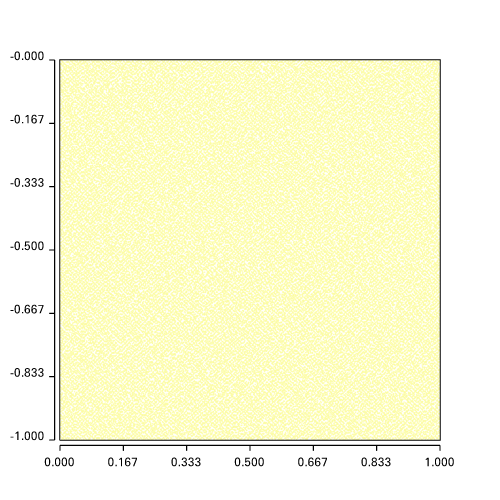

In [4]:
if uw.mpi.rank == 0:
    from underworld import visualisation as vis
    fig_res = (500,500)

    Fig = vis.Figure(resolution=fig_res,rulers=True,margin = 60,rulerticks=7,quality=3,clipmap=False)
    Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True,colourBar=False)
    Fig.show()
    Fig.save("2DShearedRectangle_Modelsetup.png")

In [5]:
with Model.mesh.deform_mesh():
     Model.mesh.data[:, 0] = Model.mesh.data[:, 0]+(Model.mesh.data[:,1]-GEO.nd(ymin_box*u.kilometer))*0.3


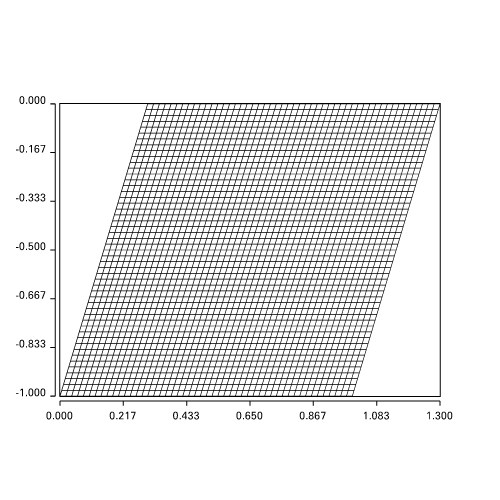

'2DShearedRectangle_mesh0.png'

In [6]:
Fig = vis.Figure(resolution=fig_res,rulers=True,margin = 60,rulerticks=7,quality=3,clipmap=False)
Fig.Mesh(Model.mesh)
Fig.show()
Fig.save('2DShearedRectangle_mesh0.png') 

In [7]:
from underworld.swarm import Swarm
from collections import OrderedDict
Model.swarm_variables = OrderedDict()

Model.swarm = Swarm(mesh=Model.mesh, particleEscape=True)
Model.swarm.allow_parallel_nn = True
if Model.mesh.dim == 2:
    particlesPerCell = GEO.rcParams["swarm.particles.per.cell.2D"]
else:
    particlesPerCell = GEO.rcParams["swarm.particles.per.cell.3D"]

Model._swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=Model.swarm,
    particlesPerCell=particlesPerCell)

Model.swarm.populate_using_layout(layout=Model._swarmLayout)

Model._initialize()

In func WeightsCalculator_CalculateAll(): for swarm "NFU88B4I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "NFU88B4I__swarm"


In [8]:
m1_Shape = fn.input()[1] <= 0.

m1 = Model.add_material(name="material 1",shape=m1_Shape)
m1_rho = 3300. * u.kilogram / u.metre**3


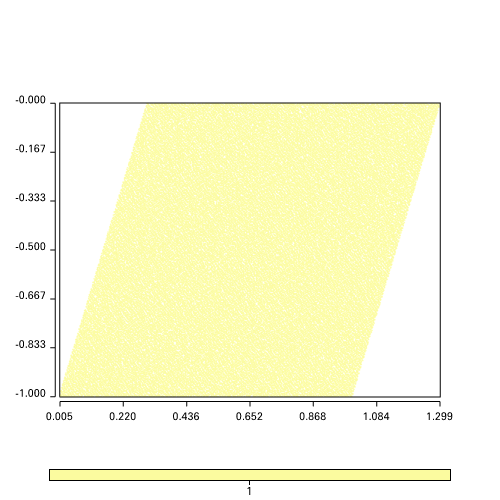

In [9]:
Fig = vis.Figure(resolution=fig_res,rulers=True,margin = 60,rulerticks=7,quality=3,clipmap=False)
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True,colourBar=True)
Fig.show()

In [10]:
###----------------------------

from copy import copy

minCoord = tuple([GEO.nd(val) for val in Model.minCoord])
maxCoord = tuple([GEO.nd(val) for val in Model.maxCoord])

elementType = "Q1"
mesh = uw.mesh.FeMesh_Cartesian(elementType=elementType,
                             elementRes=Model.elementRes,
                             minCoord=minCoord,
                             maxCoord=maxCoord,
                             periodic=Model.periodic)

gwPressureField           = mesh.add_variable( nodeDofCount=1 )
lithoPressureField        = mesh.add_variable( nodeDofCount=1 )
hydraulicDiffusivityField = mesh.add_variable( nodeDofCount=1 )
velocityField             = mesh.add_variable( nodeDofCount=2 )
velocityField.data[:]= 0.



with mesh.deform_mesh():
    mesh.data[:, 0] = mesh.data[:, 0]+(mesh.data[:,1]-GEO.nd(ymin_box*u.kilometer))*0.3

#gwPressureField.data[:] = Model.lithostatic_pressureField.evaluate(mesh)

# maxgwpressure = 0.5
# yCoordFn  = uw.function.input()[1]
# initialFn = -1. * yCoordFn * maxgwpressure
# gwPressureField.data[:] = initialFn.evaluate(mesh)


# Boundary conditions
topWall    = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]


BCsType = 2

if BCsType == 1:
#--- Case 1 $P = 0 \: (x \in \partial \Omega_{surf})$ NeumannCondition
    flux = uw.function.Function.convert(0.)
    cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=gwPressureField,indexSetsPerDof=topWall)
    
#     flux = mesh.add_variable( nodeDofCount=2 )
#     flux.data[:]=0.
#     cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=velocityField,indexSetsPerDof=[topWall,topWall])
    cond_neumann.indexSet = cond_neumann.indexSetsPerDof
    BCs = [cond_neumann]
    print("type 1")

elif BCsType == 2:
#--- Case 2 $P = 0 \: (x \in \partial \Omega_{surf})$ DirichletCondition 
    gwPressureBC = uw.conditions.DirichletCondition( variable        = gwPressureField, 
                                               indexSetsPerDof = ( topWall) )
    # gwPressureBC = uw.conditions.DirichletCondition( variable        = gwPressureField, 
    #                                                indexSetsPerDof = ( topWall+ bottomWall ))
    BCs = [gwPressureBC]

elif BCsType == 3:
#--- Case 3 $P = 0 \: (x \in \partial \Omega_{surf})$ NeumannCondition + v = 0 DirichletCondition
    AllIndexSets = mesh.specialSets["Empty"]
    for index in mesh.data_nodegId:
        AllIndexSets.add(int(index))
    cond_dirichlet =uw.conditions.DirichletCondition( variable        = velocityField, 
                                                     indexSetsPerDof = (AllIndexSets,AllIndexSets)) 
    flux = uw.function.Function.convert(0.)
    cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=gwPressureField,indexSetsPerDof=topWall)
    #cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=velocityField,indexSetsPerDof=topWall)
    cond_neumann.indexSet = cond_neumann.indexSetsPerDof
    BCs = [cond_neumann,cond_dirichlet]
else:
    print("No type of BCs settings")

# swarm = copy(Model.swarm)
# materialIndex = copy(Model.materialField)
# materialVelocity = copy(Model.velocityField)

swarm = uw.swarm.Swarm(mesh=mesh)
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=1)
swarm.populate_using_layout(swarmLayout)

materialIndex = swarm.add_variable( dataType="int",count=1 )

m1_Shape = fn.input()[1] <= 0.
m1_index = 1 
conditions = [ (m1_Shape, m1_index),]
materialfn = uw.function.branching.conditional( conditions )
materialIndex.data[:]  = materialfn.evaluate(swarm)

materialVelocity  = swarm.add_variable( dataType="double", count=2 )
materialVelocity.data[:]= 0.

Ka = 1.
hydraulicDiffusivityMap = { m1_index: Ka,}
hydraulicDiffusivityMapFn = uw.function.branching.map( fn_key = materialIndex, mapping = hydraulicDiffusivityMap )

g = uw.function.misc.constant((0.0, -GEO.nd(gravity)))
densityFn = uw.function.branching.map( fn_key=materialIndex, 
                                    mapping={ m1_index: GEO.nd(m1_rho), } )

forceFn = densityFn * (0.0,-GEO.nd(gravity))
fn_bodyforce = forceFn 

gwadvDiff = uw.systems.SteadyStateDarcyFlow(velocityField=velocityField,
                                            pressureField=gwPressureField, 
                                            fn_diffusivity = hydraulicDiffusivityMapFn,
                                            conditions=BCs,
                                            fn_bodyforce=fn_bodyforce , 
                                            voronoi_swarm=swarm,
                                            swarmVarVelocity=materialVelocity)
gwsolver = uw.systems.Solver(gwadvDiff)
gwsolver.solve()

	Global element size: 50x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x50
In func WeightsCalculator_CalculateAll(): for swarm "3E1TWYE8__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "3E1TWYE8__swarm"
Linear solver (B17ZPLPT__system-execute) 
Linear solver (B17ZPLPT__system-execute), solution time 8.376346e-03 (secs)



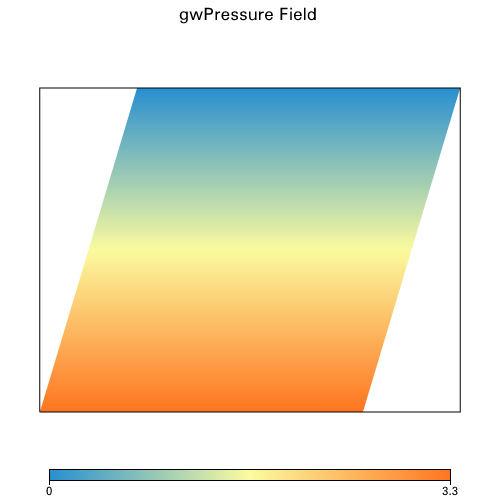

In [11]:
if uw.mpi.rank == 0:
    Fig = vis.Figure(figsize= fig_res, title="gwPressure Field", quality=3)
    #Fig.Surface(mesh,gwPressureField)
    #Fig.Contours(mesh, gwPressureField,interval= 1, limits=( 0,6),colours='Black', colourBar=False)
    Fig.Surface(mesh, GEO.dimensionalise(gwPressureField, u.megapascal)/1000.)
    #Fig.VectorArrows(mesh, velocityField) 
    #Fig.Contours(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal), interval= 500, limits=( 0,4000.),colours='Black', colourBar=False)
    Fig.show()
    Fig.save_image("2DShearedRectangle_pressure.png")